In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from scipy import stats
from scipy.linalg import norm
%matplotlib inline

In [2]:
df_train = pd.read_csv(r'D:/实习prepare/house_price_analysis/kaggle_house_pred_train.csv')

In [3]:
na_count = df_train.isnull().sum().sort_values(ascending=False)
na_rate = na_count / len(df_train)
na_data = pd.concat([na_count,na_rate],axis=1,keys=['count','ratio'])
na_data.head(20)

,count,ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [4]:
df_train = df_train.drop(na_data[na_data['count']>1].index, axis=1)  # 删除上述前18个特征 
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)  # 删除 Electrical 取值丢失的样本
df_train.shape  # 缺失值处理后的数据大小：1459个样本，63个特征

(1459, 63)

In [6]:
df_tr = pd.read_csv(r'D:/实习prepare/house_price_analysis/kaggle_house_pred_train.csv').drop('Id',axis=1)
df_X = df_tr.drop('SalePrice',axis=1)
df_y = df_tr['SalePrice']
quantity = [attr for attr in df_X.columns if df_X.dtypes[attr] != 'object']  # 数值变量集合
quality = [attr for attr in df_X.columns if df_X.dtypes[attr] == 'object']  # 类型变量集合

for c in quality:  # 类型变量缺失值补全
    df_tr[c] = df_tr[c].astype('category')
    if df_tr[c].isnull().any():
        df_tr[c] = df_tr[c].cat.add_categories(['MISSING'])
        df_tr[c] = df_tr[c].fillna('MISSING')

# 连续变量缺失值补全 
quantity_miss_cal = df_tr[quantity].isnull().sum().sort_values(ascending=False)  # 缺失量均在总数据量的10%以下
missing_cols = quantity_miss_cal[quantity_miss_cal>0].index
df_tr[missing_cols] = df_tr[missing_cols].fillna(0.)  # 从这些变量的意义来看，缺失值很可能是取 0
df_tr[missing_cols].isnull().sum()  # 验证缺失值是否都已补全

LotFrontage    0
GarageYrBlt    0
MasVnrArea     0
dtype: int64

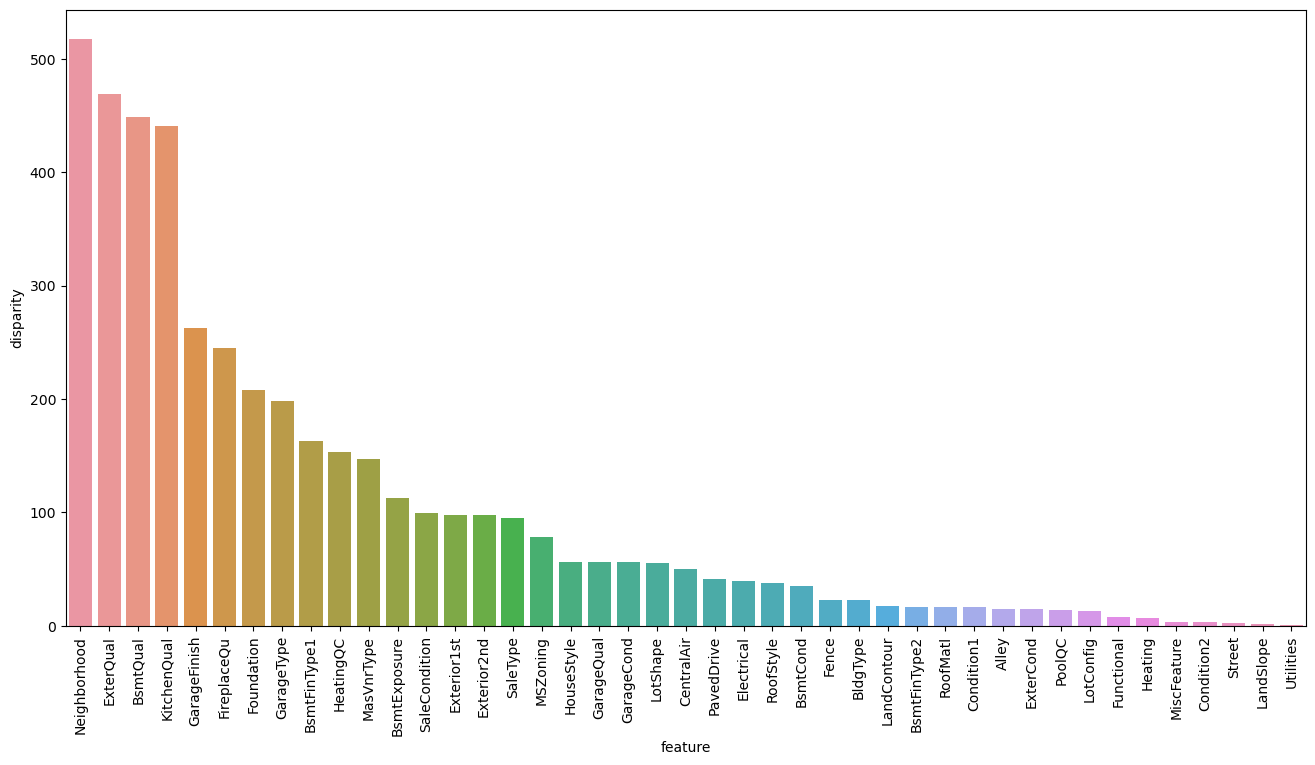

In [7]:
# 一元方差分析（类型变量）
def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)  # 某特征下不同取值对应的房价组合形成二维列表
        pval = stats.f_oneway(*samples)[1]  # 一元方差分析得到 F，P，要的是 P，P越小，对方差的影响越大。
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df_tr,quality)
a['disparity'] = np.log(1./a['pval'].values)  # 悬殊度
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)
plt.show()

In [8]:
def encode(frame, feature):
    '''
    对所有类型变量，依照各个类型变量的不同取值对应的样本集内房价的均值，按照房价均值高低
    对此变量的当前取值确定其相对数值1,2,3,4等等，相当于对类型变量赋值使其成为连续变量。
    此方法采用了与One-Hot编码不同的方法来处理离散数据，值得学习
    注意：此函数会直接在原frame的DataFrame内创建新的一列来存放feature编码后的值。
    '''
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['price_mean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # 上述 groupby()操作可以将某一feature下同一取值的数据整个到一起，结合mean()可以直接得到该特征不同取值的房价均值
    ordering = ordering.sort_values('price_mean')
    ordering['order'] = range(1, ordering.shape[0]+1)
    ordering = ordering['order'].to_dict()
    for attr_v, score in ordering.items():
        # e.g. qualitative[2]: {'Grvl': 1, 'MISSING': 3, 'Pave': 2}
        frame.loc[frame[feature] == attr_v, feature+'_E'] = score

quality_encoded = []
# 由于qualitative集合中包含了非数值型变量和伪数值型变量（多为评分、等级等，其取值为1,2,3,4等等）两类
# 因此只需要对非数值型变量进行encode()处理。
# 如果采用One-Hot编码，则整个qualitative的特征都要进行pd,get_dummies()处理
for q in quality:
    encode(df_tr, q)
    quality_encoded.append(q+'_E')
df_tr.drop(quality, axis=1, inplace=True)  # 离散变量已经有了编码后的新变量，因此删去原变量
# df_tr.shape = (1460, 80)
print(quality_encoded, '\n{} qualitative attributes have been encoded.'.format(len(quality_encoded)))

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E'] 
43 qualitative attributes have been encoded.


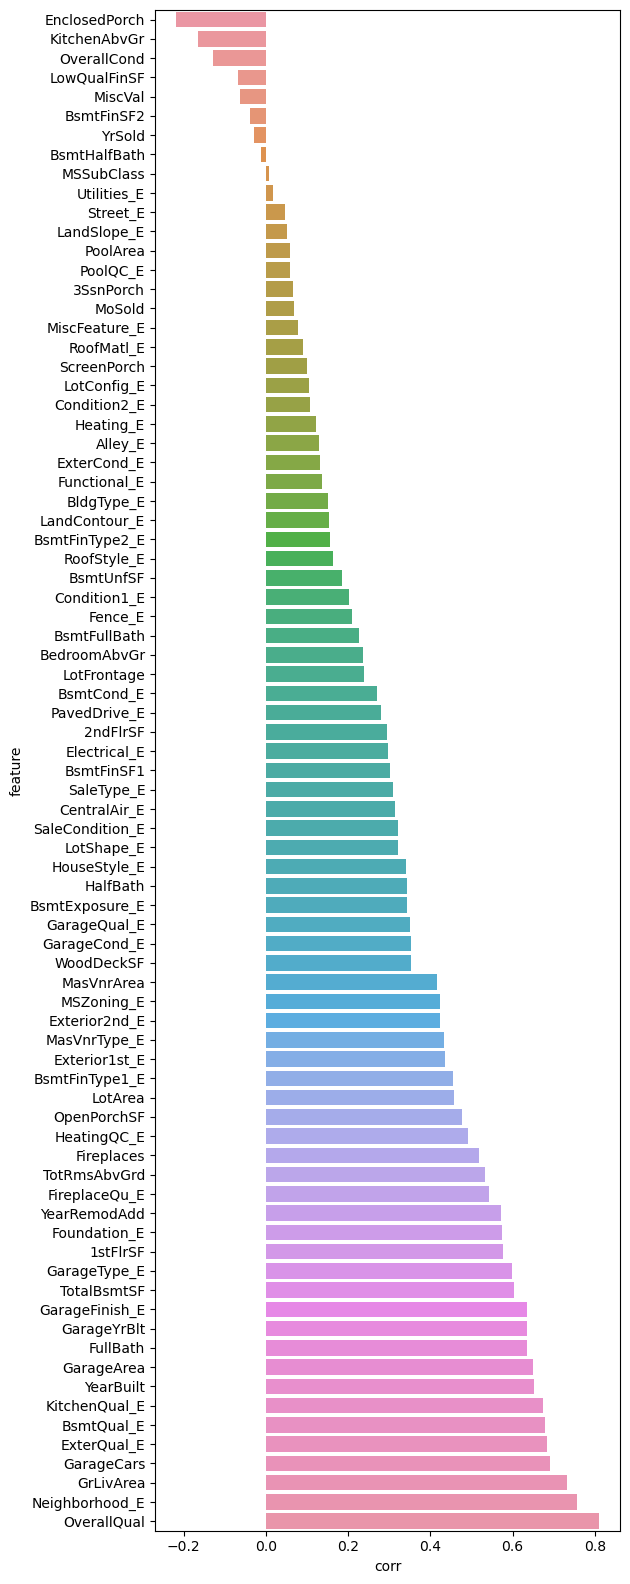

In [9]:
def spearman(frame, features):
    '''
    采用“斯皮尔曼等级相关”来计算变量与房价的相关性(可查阅百科)
    此相关系数简单来说，可以对上述encoder()处理后的等级变量及其它与房价的相关性进行更好的评价（特别是对于非线性关系）
    '''
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['corr'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('corr')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='corr', orient='h')    
features = quantity + quality_encoded
spearman(df_tr, features)

<AxesSubplot:>

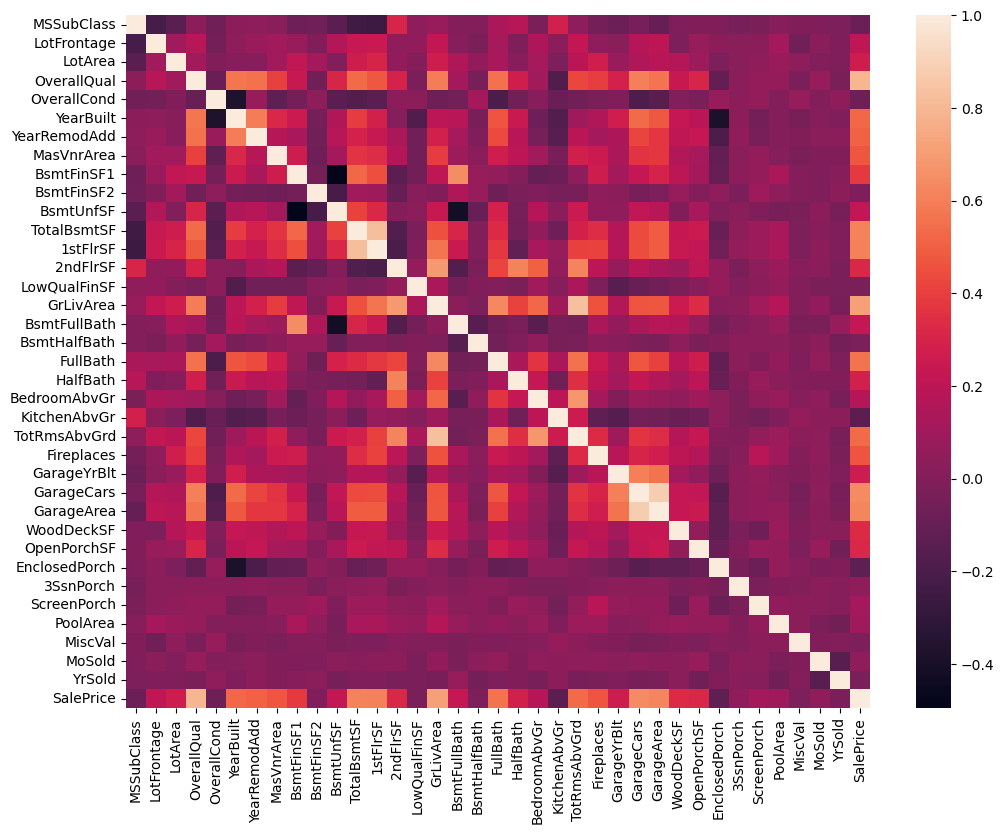

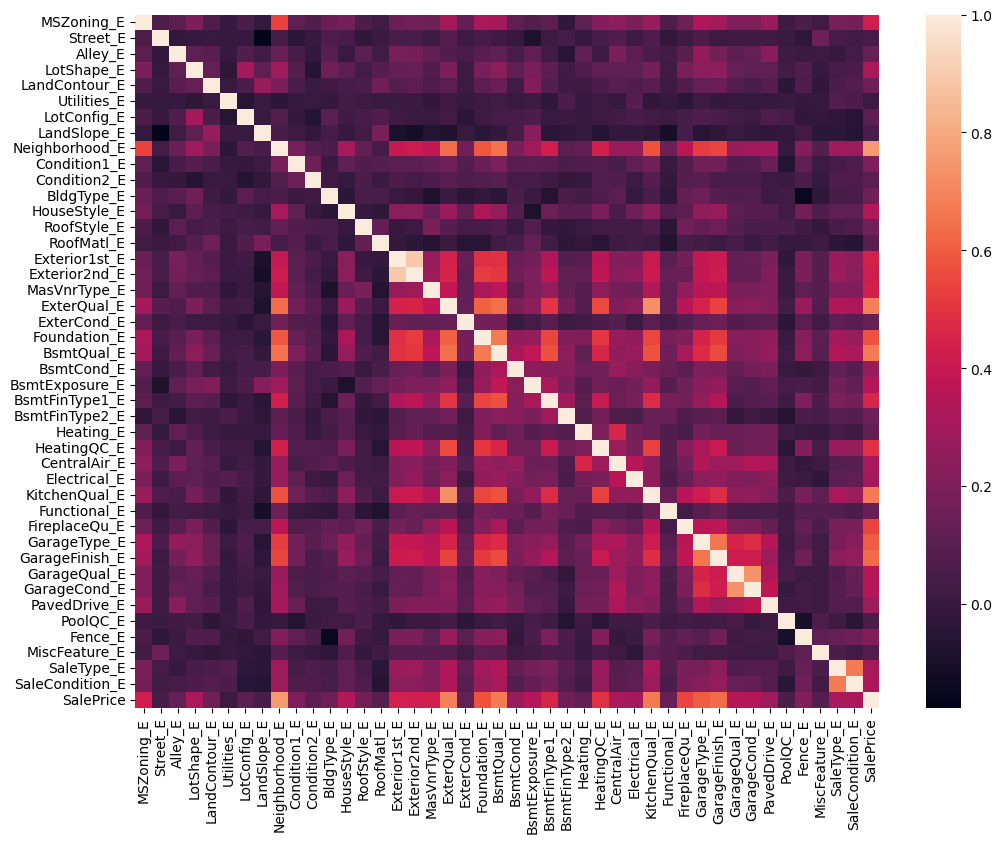

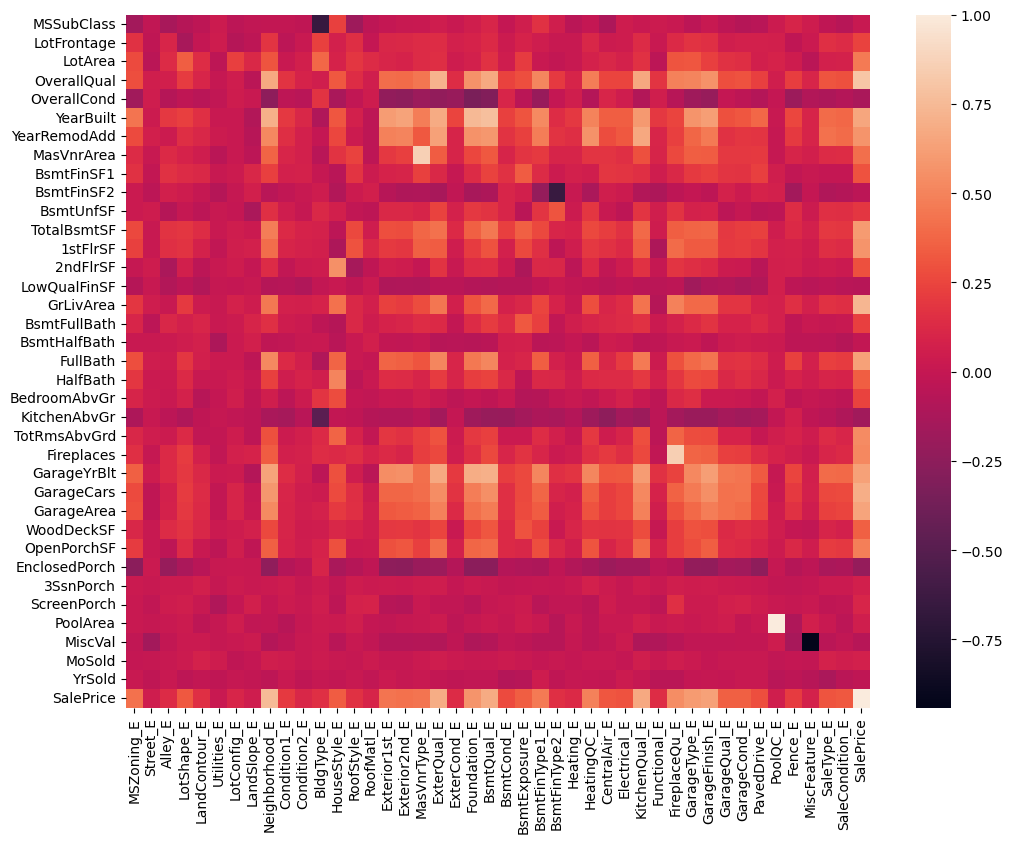

In [10]:
plt.figure(1,figsize=(12,9))  # 连续型变量相关图
corr = df_tr[quantity+['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(2,figsize=(12,9))  # 等级型变量相关图（离散型和伪数值型变量均已被概括为等级型变量）
corr = df_tr[quality_encoded+['SalePrice']].corr('spearman')
sns.heatmap(corr)

plt.figure(3,figsize=(12,9)) # 连续型变量-等级型变量相关图
corr = pd.DataFrame(np.zeros([len(quantity)+1, len(quality_encoded)+1]), 
                    index=quantity+['SalePrice'], columns=quality_encoded+['SalePrice'])
for q1 in quantity+['SalePrice']:
    for q2 in quality_encoded+['SalePrice']:
        corr.loc[q1, q2] = df_tr[q1].corr(df_tr[q2], 'spearman')
sns.heatmap(corr)

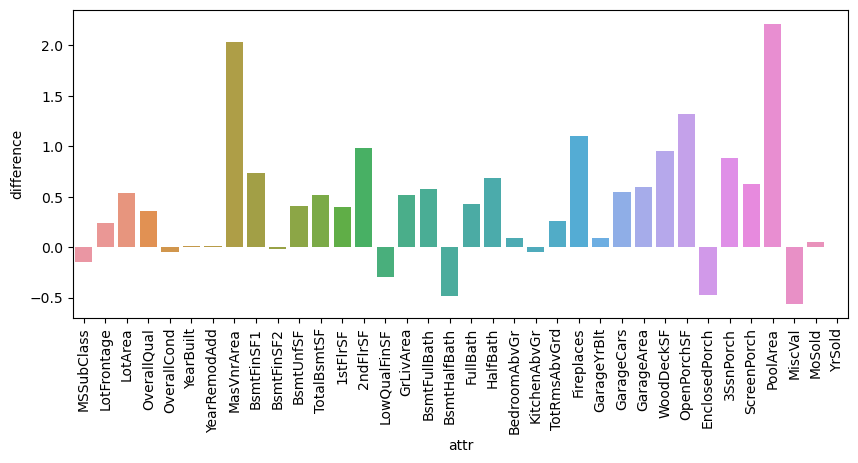

In [11]:
# 给房价分段，并由此查看各段房价内那些特征的取值会出现悬殊
poor = df_tr[df_tr['SalePrice'] < 200000][quantity].mean()
pricey = df_tr[df_tr['SalePrice'] >= 200000][quantity].mean()
diff = pd.DataFrame()
diff['attr'] = quantity
diff['difference'] = ((pricey-poor)/poor).values
plt.figure(figsize=(10,4))
sns.barplot(data=diff, x='attr', y='difference')
plt.xticks(rotation=90)
plt.show()

In [12]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
low_range = np.sort(saleprice_scaled,axis=0)[:10,0]
high_range = np.sort(saleprice_scaled,axis=0)[-10:,0]
high_range

C:\Users\wxq\AppData\Local\Temp\ipykernel_8880\4227415503.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])


array([3.82758058, 4.0395221 , 4.49473628, 4.70872962, 4.728631  ,
       5.06034585, 5.42191907, 5.58987866, 7.10041987, 7.22629831])

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

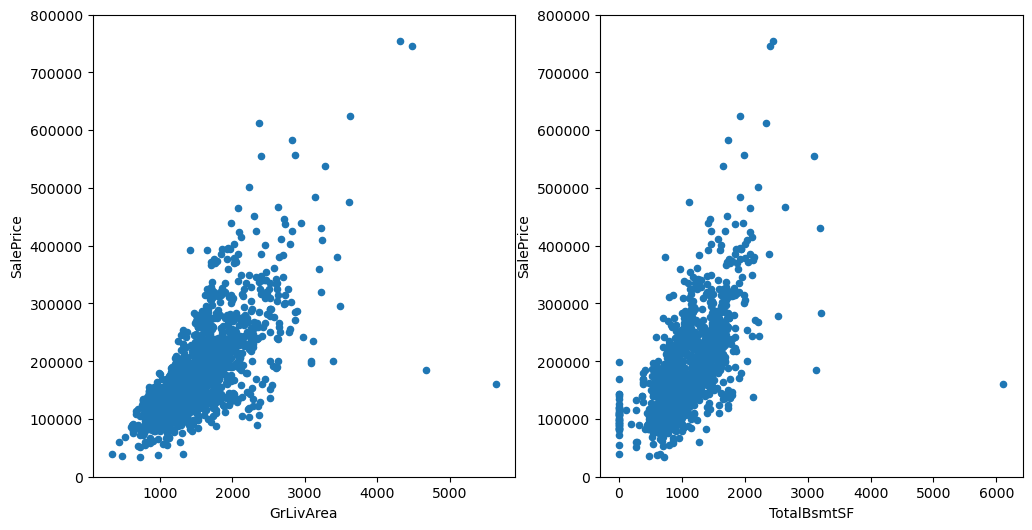

In [13]:
output,var,var1 = 'SalePrice', 'GrLivArea', 'TotalBsmtSF'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
df_train.plot.scatter(x=var,y=output,ylim=(0,800000),ax=axes[0])
df_train.plot.scatter(x=var1,y=output,ylim=(0,800000),ax=axes[1])

In [14]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]  # 查找离群点

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [15]:
# 删除离群点
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


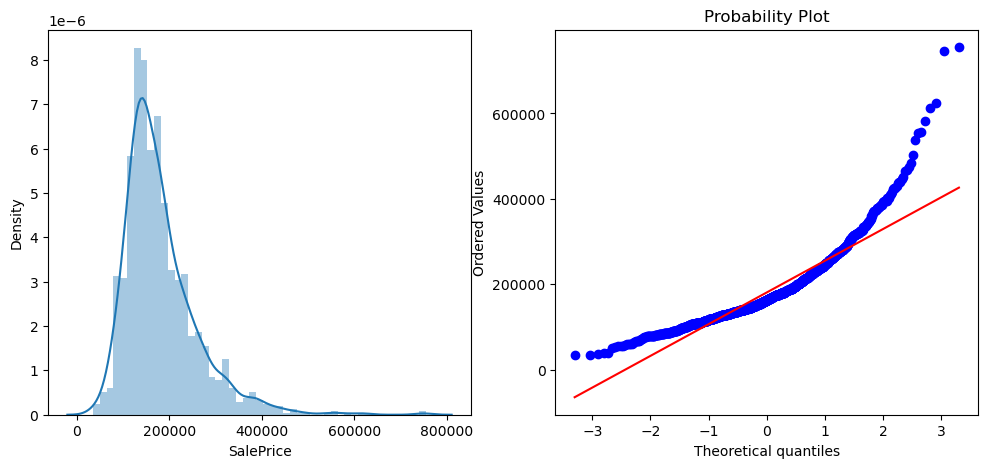

In [24]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(df_train[output])
plt.subplot(122)
res = stats.probplot(df_train[output], plot=plt)
plt.show()

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

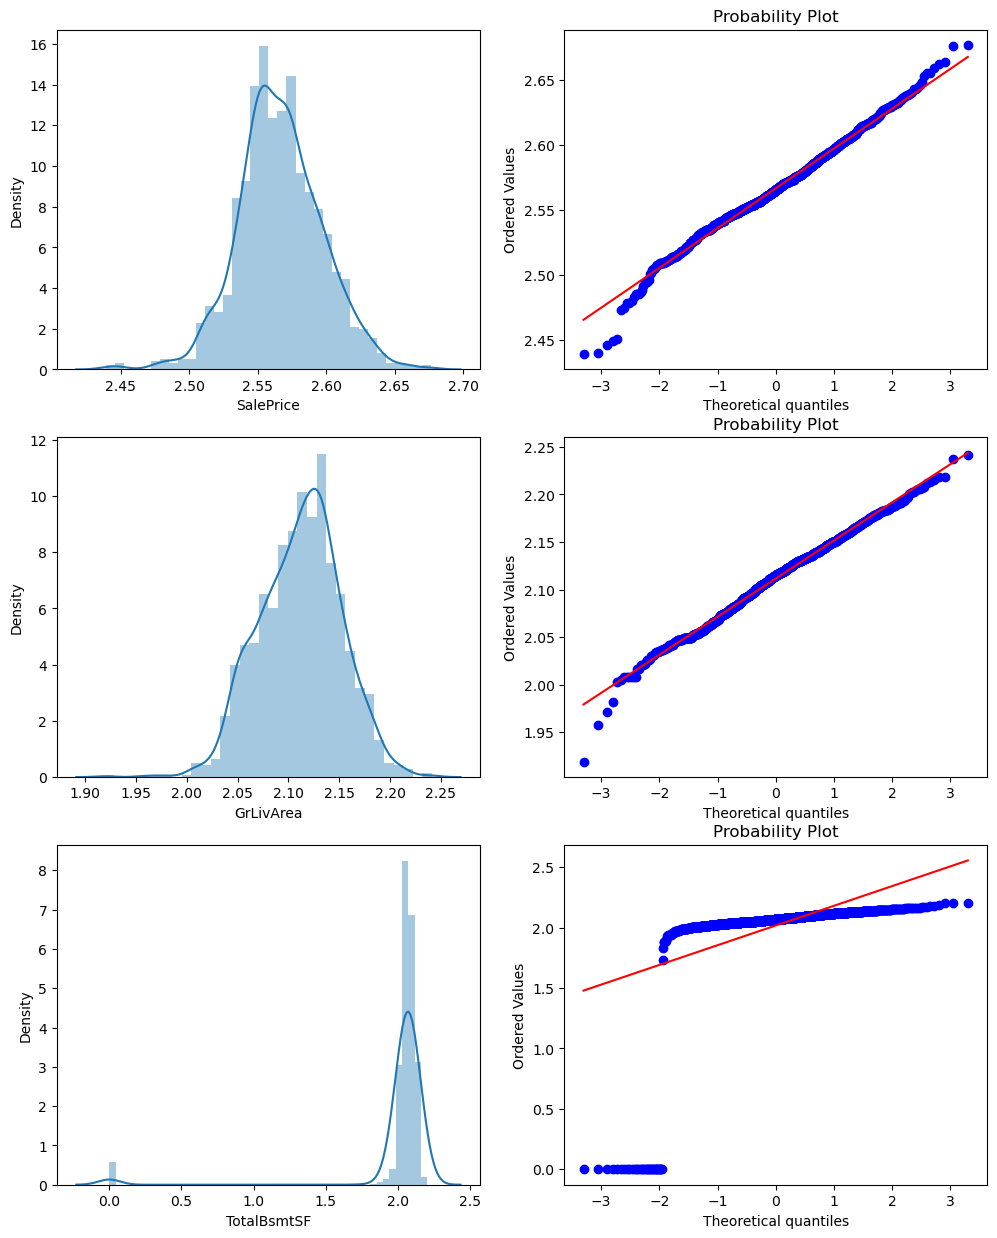

In [26]:
def log_transform(feature):
    # np.log1p(x) = log(1+x)，这样就可以对0值求对数（针对 `TotalBsmtSF` 这样含有0的特征）
    df_train[feature] = np.log1p(df_train[feature].values)  

log_transform(output)
log_transform(var)
log_transform(var1)
fig = plt.figure(figsize=(12,15))
plt.subplot(321)
sns.distplot(df_train[output])
plt.subplot(322)
res = stats.probplot(df_train[output], plot=plt)
plt.subplot(323)
sns.distplot(df_train[var])
plt.subplot(324)
res = stats.probplot(df_train[var], plot=plt)
plt.subplot(325)
sns.distplot(df_train[var1])
plt.subplot(326)
res = stats.probplot(df_train[var1], plot=plt)
plt.show()

In [27]:
df_tr['HasBasement'] = df_tr['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasGarage'] = df_tr['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_tr['Has2ndFloor'] = df_tr['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasMasVnr'] = df_tr['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasWoodDeck'] = df_tr['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasPorch'] = df_tr['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasPool'] = df_tr['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_tr['IsNew'] = df_tr['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 
           'HasWoodDeck', 'HasPorch', 'HasPool', 'IsNew']

def quadratic(feature):
    df_tr[feature] = df_tr[feature[:-1]]**2

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']
for feature in qdr:
    quadratic(feature)

In [28]:
df_train = pd.get_dummies(df_train)
df_train.shape   # 未考虑上述增加特征时的运行结果

(1457, 221)